In [6]:
import input_data
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_dataset = input_data.read_data_sets('..\homework-2\MNIST_data', one_hot=True)

Extracting ..\homework-2\MNIST_data\train-images-idx3-ubyte.gz
Extracting ..\homework-2\MNIST_data\train-labels-idx1-ubyte.gz
Extracting ..\homework-2\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ..\homework-2\MNIST_data\t10k-labels-idx1-ubyte.gz


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(mnist_dataset.train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(mnist_dataset.test, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64, 10])


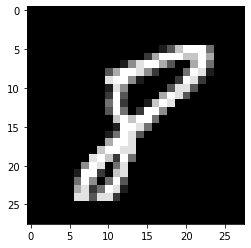

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=torch.float64)


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().reshape((28,28))
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
image.shape

(784,)

In [8]:
label.shape

(10,)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 7x7 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1,8,3,1,1)
        self.conv2 = nn.Conv2d(8, 16, 3,1,1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 128)  # 7*7 from image dimension
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [26]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[ 0.0420, -0.0437, -0.0061,  0.0443,  0.0258,  0.0962,  0.0337, -0.0634,
          0.1032, -0.1711]], grad_fn=<AddmmBackward>)


In [14]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9993, grad_fn=<MseLossBackward>)


In [27]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the updat

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X=X.reshape(X.shape[0],1,28,28)
        pred = model(X)
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X=X.reshape(X.shape[0],1,28,28)
            pred = model(X)
            test_loss += loss_fn(pred, y.float()).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [24]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_fn=criterion
train_loop(train_dataloader, net, loss_fn, optimizer)

loss: 0.099750  [    0/55000]
loss: 0.096472  [ 6400/55000]
loss: 0.091240  [12800/55000]
loss: 0.090777  [19200/55000]
loss: 0.090016  [25600/55000]
loss: 0.089679  [32000/55000]
loss: 0.089540  [38400/55000]
loss: 0.088702  [44800/55000]
loss: 0.089292  [51200/55000]


In [34]:
test_loop(test_dataloader, net, loss_fn)

Test Error: 
 Accuracy: 19.9%, Avg loss: 0.089011 



In [37]:
loss_fn =  nn.MSELoss()
#nn.CrossEntropyLoss()
model=net
learning_rate=0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.088971  [    0/55000]
loss: 0.089108  [ 6400/55000]
loss: 0.088839  [12800/55000]
loss: 0.088776  [19200/55000]
loss: 0.088461  [25600/55000]
loss: 0.088963  [32000/55000]
loss: 0.088308  [38400/55000]
loss: 0.088682  [44800/55000]
loss: 0.088109  [51200/55000]
Test Error: 
 Accuracy: 44.1%, Avg loss: 0.088135 

Epoch 2
-------------------------------
loss: 0.087905  [    0/55000]
loss: 0.087833  [ 6400/55000]
loss: 0.087753  [12800/55000]
loss: 0.087971  [19200/55000]
loss: 0.087636  [25600/55000]
loss: 0.087572  [32000/55000]
loss: 0.087318  [38400/55000]
loss: 0.087032  [44800/55000]
loss: 0.086954  [51200/55000]
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.086798 

Epoch 3
-------------------------------
loss: 0.086825  [    0/55000]
loss: 0.086707  [ 6400/55000]
loss: 0.086408  [12800/55000]
loss: 0.086261  [19200/55000]
loss: 0.085823  [25600/55000]
loss: 0.085904  [32000/55000]
loss: 0.084958  [38400/55000]
loss: 0.085268  [44800/550